## 1) Read FITS files in a numeric range from a directory

Set the input directory, the filename pattern (assumes files named like `n123.fits`), and the start/end indices. The code will build the filenames and read them.

In [3]:
# Parameters: edit these to match your data
wavelength = "H"
input_dir = "/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/"  # directory with n###.fits files
file_prefix = 'n'  # files like n0.fits, n10.fits or n001.fits depending on your naming
file_suffix = '.fits'
start_index = 3  # inclusive
end_index = 39   # inclusive; if you want 0..18 (19 files)
flat_file = '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0001.fits'  # path to no-wollaston image with same wavelength, but different t_int

# List of file numbers to skip (e.g., [7, 13, 21])
skip_indices = []  # edit this list as needed

# Build list of filenames
from pathlib import Path
import numpy as np
input_dir = Path(input_dir)
files = []
for i in range(start_index, end_index + 1):
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    # zero-pad the numeric index to 4 digits, e.g., 5 -> 0005
    idx_str = f"{i:04d}"
    fname = input_dir / f"{file_prefix}{idx_str}{file_suffix}"
    if fname.exists():
        files.append(str(fname))
    else:
        print(f"Warning: {fname} not found")

print(f'Found {len(files)} files to process')

print(files)


Found 37 files to process
['/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0003.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0004.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0005.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0006.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0007.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0008.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0009.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0010.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0011.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0012.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0013.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0014.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0015.fits', '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/n0016.fits', '/home/shared/exoserv

# Dark Subtraction Script

In [4]:
# --- DARK SUBTRACTION SCRIPT ---
from astropy.io import fits
import numpy as np
from pathlib import Path

# User parameters:
dark_file = '/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025sep18/n0007.fits' # path to master dark
output_dark_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/" + wavelength + "-Band/Dark_Subtracted_Data")  # directory to save dark-subtracted files
output_dark_dir.mkdir(parents=True, exist_ok=True)

# Load dark
with fits.open(dark_file) as hdudark:
    dark = hdudark[0].data.astype(float)

# Dark subtract and save each file
for f in files:
    with fits.open(f) as hdu:
        data = hdu[0].data.astype(float)
        header = hdu[0].header
    if data.shape != dark.shape:
        print(f'Skipping {Path(f).name}: shape mismatch with dark')
        continue
    sub = data - dark
    outname = output_dark_dir / (Path(f).stem + '_darksub.fits')
    fits.writeto(outname, sub.astype(np.float32), header=header, overwrite=True)
    print(f'Saved {outname.name}')


Saved n0003_darksub.fits
Saved n0004_darksub.fits
Saved n0005_darksub.fits
Saved n0006_darksub.fits
Saved n0007_darksub.fits
Saved n0008_darksub.fits
Saved n0009_darksub.fits
Saved n0010_darksub.fits
Saved n0011_darksub.fits
Saved n0012_darksub.fits
Saved n0013_darksub.fits
Saved n0014_darksub.fits
Saved n0015_darksub.fits
Saved n0016_darksub.fits
Saved n0017_darksub.fits
Saved n0018_darksub.fits
Saved n0019_darksub.fits
Saved n0020_darksub.fits
Saved n0021_darksub.fits
Saved n0022_darksub.fits
Saved n0023_darksub.fits
Saved n0024_darksub.fits
Saved n0025_darksub.fits
Saved n0026_darksub.fits
Saved n0027_darksub.fits
Saved n0028_darksub.fits
Saved n0029_darksub.fits
Saved n0030_darksub.fits
Saved n0031_darksub.fits
Saved n0032_darksub.fits
Saved n0033_darksub.fits
Saved n0034_darksub.fits
Saved n0035_darksub.fits
Saved n0036_darksub.fits
Saved n0037_darksub.fits
Saved n0038_darksub.fits
Saved n0039_darksub.fits


## 2) Flat-field all files using a specified flat FITS file

This cell will open the flat field image and divide each science frame by the flat. It performs a small sigma-clipped normalization of the flat before applying to avoid scaling issues.

In [5]:
# --- SIMPLE FLAT-FIELDING SCRIPT (on dark-subtracted data) ---
from astropy.io import fits
import numpy as np
from pathlib import Path

# User parameters:
input_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/" + wavelength + "-Band/Dark_Subtracted_Data/")  # directory with dark-subtracted FITS files
output_flat_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/" + wavelength + "-Band/Flat_Fielded_Data/")  # directory to save flat-fielded files
output_flat_dir.mkdir(parents=True, exist_ok=True)

# Load flat
hdul = fits.open(flat_file)
primary_hdu = hdul[0]
flat = (primary_hdu.data - dark) / np.median(primary_hdu.data - dark)

# Replace zeros or NaNs in flat with median of good pixels
#mask_good = np.isfinite(flat) & (flat > 0)
#if not np.any(mask_good):
#    raise RuntimeError('Flat field contains no positive finite pixels')
#flat_median = np.median(flat[mask_good])
#flat[~mask_good] = flat_median

for i in range(start_index, end_index + 1):
    idx_str = f"{i:04d}"
    file_suffix2 = '_darksub.fits'
    fname = input_dir / f"{file_prefix}{idx_str}{file_suffix2}"
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    with fits.open(fname) as hdu:
        data = hdu[0].data.astype(float)
        header = hdu[0].header
    if data.shape != flat.shape:
        print(f'Skipping {fname.name}: shape mismatch')
        continue
    with np.errstate(divide='ignore', invalid='ignore'):
        ff = np.divide(data, flat, out=np.full_like(data, np.nan), where=(flat != 0))
    ff[~np.isfinite(ff)] = np.nan
    outname = output_flat_dir / (fname.stem.replace('_darksub','') + '_flatfielded.fits')
    fits.writeto(outname, ff.astype(np.float32), header=header, overwrite=True)
    print(f'Saved {outname.name}')

Saved n0003_flatfielded.fits
Saved n0004_flatfielded.fits
Saved n0005_flatfielded.fits
Saved n0006_flatfielded.fits
Saved n0007_flatfielded.fits
Saved n0008_flatfielded.fits
Saved n0009_flatfielded.fits
Saved n0010_flatfielded.fits
Saved n0011_flatfielded.fits
Saved n0012_flatfielded.fits
Saved n0013_flatfielded.fits
Saved n0014_flatfielded.fits
Saved n0015_flatfielded.fits
Saved n0016_flatfielded.fits
Saved n0017_flatfielded.fits
Saved n0018_flatfielded.fits
Saved n0019_flatfielded.fits
Saved n0020_flatfielded.fits
Saved n0021_flatfielded.fits
Saved n0022_flatfielded.fits
Saved n0023_flatfielded.fits
Saved n0024_flatfielded.fits
Saved n0025_flatfielded.fits
Saved n0026_flatfielded.fits
Saved n0027_flatfielded.fits
Saved n0028_flatfielded.fits
Saved n0029_flatfielded.fits
Saved n0030_flatfielded.fits
Saved n0031_flatfielded.fits
Saved n0032_flatfielded.fits
Saved n0033_flatfielded.fits
Saved n0034_flatfielded.fits
Saved n0035_flatfielded.fits
Saved n0036_flatfielded.fits
Saved n0037_fl

## 3) Rectangular aperture photometry (two apertures) and save results

We define two rectangular apertures by (x0, x1, y0, y1). The code sums pixels inside each aperture for every flat-fielded image. The top aperture sums are saved into `top_fluxes.npy` and the bottom into `bottom_fluxes.npy`.

Adjust the aperture coordinates to match your data. Coordinates are in pixel indices with origin (0,0) at the FITS array's [0,0].

In [6]:
# Aperture coordinates (edit as needed)
# top aperture: x from x0_top..x1_top (inclusive start, exclusive end), y from y0_top..y1_top
x0_top, x1_top = 20, 1000
y0_top, y1_top = 520, 900
# bottom aperture
x0_bot, x1_bot = 20, 1000
y0_bot, y1_bot = 10, 490

from pathlib import Path
from astropy.io import fits
import numpy as np

# Directory containing flat-fielded images
flat_dir = Path("/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/" + wavelength + "-Band/Flat_Fielded_Data/")
flat_files = sorted(flat_dir.glob('*_flatfielded.fits'))
print(flat_files)
print(f'Found {len(flat_files)} flat-fielded files')

top_fluxes = []
bottom_fluxes = []

for i in range(start_index, end_index + 1):
    idx_str = f"{i:04d}"
    file_suffix3 = '_flatfielded.fits'
    fname = flat_dir / f"{file_prefix}{idx_str}{file_suffix3}"
    if i in skip_indices:
        print(f"Skipping file number {i} (in skip_indices)")
        continue
    try:
        with fits.open(fname) as hdu:
            img = hdu[0].data.astype(float)
    except Exception as e:
        print(f'Error loading {fname}: {e}')
        top_fluxes.append(np.nan)
        bottom_fluxes.append(np.nan)
        continue

    # Safety: ensure indices are within bounds
    h, w = img.shape
    def clip_coords(a0, a1, maxv):
        a0 = max(0, min(maxv, a0))
        a1 = max(0, min(maxv, a1))
        return a0, a1
    x0t, x1t = clip_coords(x0_top, x1_top, w)
    y0t, y1t = clip_coords(y0_top, y1_top, h)
    x0b, x1b = clip_coords(x0_bot, x1_bot, w)
    y0b, y1b = clip_coords(y0_bot, y1_bot, h)

    #print(np.nansum(img[y0t:y1t, x0t:x1t]))
    #print(np.nansum(img[y0b:y1b, x0b:x1b]))
    top_sum = np.nansum(img[y0t:y1t, x0t:x1t])
    bot_sum = np.nansum(img[y0b:y1b, x0b:x1b])
    top_fluxes.append(top_sum)
    bottom_fluxes.append(bot_sum)

top_fluxes = np.array(top_fluxes)
bottom_fluxes = np.array(bottom_fluxes)

print(top_fluxes)
print(len(top_fluxes))
print(bottom_fluxes)

# Save as text files in the current directory
np.savetxt('top_fluxes.txt', top_fluxes, fmt='%.6e')
print("Saved top_fluxes.txt in current directory")
np.savetxt('bottom_fluxes.txt', bottom_fluxes, fmt='%.6e')
print('Saved bottom_fluxes.txt in current directory')

[PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0003_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0004_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0005_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0006_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0007_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0008_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0009_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band/Flat_Fielded_Data/n0010_flatfielded.fits'), PosixPath('/home/shared/exoserver/NIRC2_Pol/Dome_Flats/2025oct02/H-Band

## 4) Plot normalized difference vs HWP angle

Compute abs(top - bottom)/(top + bottom) and plot versus angles from 0 to 180 in steps of 10 degrees. If number of angles doesn't match number of files, the code will use the smaller of the two and warn.

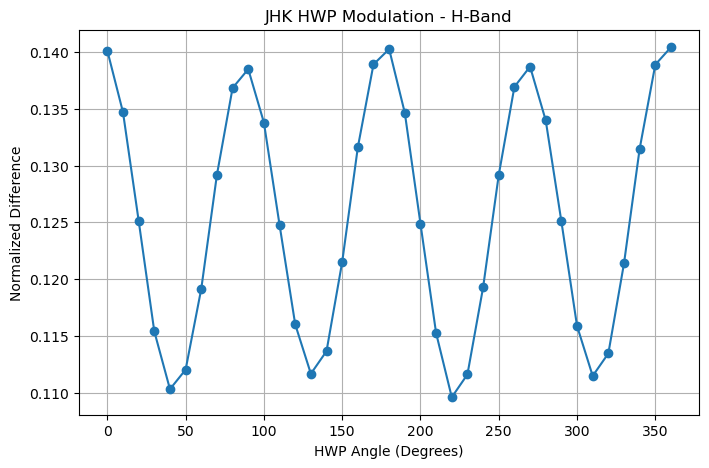

Plot saved to normalized_difference_vs_angle.png


<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

angles = np.arange(0, 361, 10)  # 0..180 step 10
n_angles = len(angles)
n_files = len(top_fluxes)
if n_angles != n_files:
    print(f'Warning: number of angles ({n_angles}) != number of files ({n_files}). Using min length.')
L = min(n_angles, n_files)
angles = angles[:L]
top = top_fluxes[:L]
bot = bottom_fluxes[:L]

# Avoid division by zero
den = top + bot
with np.errstate(divide='ignore', invalid='ignore'):
    norm_diff = np.abs(top - bot) / den

plt.figure(figsize=(8,5))
plt.plot(angles, norm_diff, marker='o')
plt.xlabel('HWP Angle (Degrees)')
plt.ylabel("Normalized Difference")
plt.grid(True)
plt.title("JHK HWP Modulation - " + wavelength + "-Band")
plt.show()

# Save plot
plt.savefig("normalized_difference_vs_angle.png", dpi=200)
print("Plot saved to normalized_difference_vs_angle.png")

### Notes and edge-cases

- Empty or missing files: the code prints warnings and writes NaN for fluxes.
- Shape mismatch between flat and frames raises an error to avoid silent incorrect results.
- Aperture coordinates are clipped to array bounds.
- Division by zero in normalized difference is handled with NumPy's errstate and will produce `nan` for invalid points.

Change the parameters in the first code cell to match your environment and filenames.